In [1]:
# Standard library imports
import copy
from datetime import datetime
import os
from pathlib import Path
import gzip
import pickle

from collections import Counter

# Related third party imports
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import imageio
import numpy as np
import open3d as o3d
import torch
import torch.nn.functional as F
from tqdm import tqdm, trange

from conceptgraph.dataset.datasets_common import get_dataset

from conceptgraph.slam.slam_classes import MapObjectList, DetectionList
from conceptgraph.scripts.visualize_cfslam_results import load_result

%load_ext autoreload
%autoreload 2

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


[2024-04-11 09:34:59,793] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [2]:
replica_root = "/rvl-home/guqiao/rdata/Replica/"
scene_name = "room0"

dataset_config_path = "/rvl-home/guqiao/src/concept-graphs/conceptgraph/dataset/dataconfigs/replica/replica.yaml"

dataset = get_dataset(
    dataconfig = dataset_config_path, 
    stride=5,
    basedir=replica_root,
    sequence=scene_name,
    device="cpu",
    dtype=torch.float,
)

def get_det_result(color_path, detection_folder_name="gsa_detections_ram_withbg_allclasses"):
    color_path = Path(color_path)
    detections_path = color_path.parent.parent / detection_folder_name / color_path.name
    detections_path = detections_path.with_suffix(".pkl.gz")
    color_path = str(color_path)
    detections_path = str(detections_path)
    
    with gzip.open(detections_path, "rb") as f:
        gobs = pickle.load(f)
    return gobs

Done! Execution time of get_dataset function: 0.07 seconds


In [3]:
result_path = "/rvl-home/guqiao/rdata/Replica/room0/pcd_saves/full_pcd_ram_withbg_allclasses_overlap_maskconf0.25_simsum1.2_dbscan.1_masksub_20230814_164846_post.pkl.gz"

objects, bg_objects, class_colors = load_result(result_path)

print(f"Loaded {len(objects)} objects and {len(bg_objects)} bg objects")

Loaded 58 objects and 3 bg objects


In [ ]:
for oid, obj in enumerate(objects):
    print(f"Object {oid}: {Counter(obj['class_name'])}")

    for det_id in range(len(obj['image_idx'])):
        image_id = obj['image_idx'][det_id]
        mask_id = obj['mask_idx'][det_id]
        
        print(f"Image {image_id}, mask {mask_id}")
        color, _, _, _ = dataset[image_id]
        color = color.detach().cpu().numpy()
        color = color.round().astype(np.uint8)

        # Load the mask from the original detection file        
        # color_path = dataset.color_paths[image_id]
        # gobs = get_det_result(color_path)
        # mask = gobs['mask'][mask_id]
        
        # Use the cached masks in objects
        mask = obj['mask'][det_id]

        mask = mask.astype(float)
        mask = cv2.resize(mask, (color.shape[1], color.shape[0]), interpolation=cv2.INTER_NEAREST)
        mask = (mask > 0.5)
        
        plt.imshow(color)
        plt.show()
        plt.imshow(mask)
        plt.show()
        
        break
    
    break

In [6]:
for oid, obj in enumerate(objects):
    print(f"Object {oid}: {Counter(obj['class_name'])}")
    
    n_points = len(obj['pcd'].points)
    pcd_points = np.asarray(obj['pcd'].points)
    pcd_center = pcd_points.mean(axis=0)
    pcd_extent = pcd_points.max(axis=0) - pcd_points.min(axis=0)
    
    vis_points = np.asarray(obj['n_points'])
    vis_ratio = vis_points / n_points
    
    image_idx = np.asarray(obj['image_idx'])
    
    vis_ratio_all = np.zeros(len(dataset))
    vis_ratio_all[image_idx] = vis_ratio
    
    print(f"Number of points: {n_points}")
    print(f"Center: {pcd_center}")
    print(f"Extent: {pcd_extent}")
    print(f"vis_ratio_all: {vis_ratio_all.max()}, {vis_ratio_all.min()}")
    
    break

Object 0: Counter({'lamp': 141})
Number of points: 604
Center: [ 2.27491015 -0.71740223 -0.26755056]
Extent: [0.42613317 0.42136103 0.27117018]
vis_ratio_all: 1.216887417218543, 0.0


Object a 1: Counter({'stool': 107, 'furniture': 30, 'armchair': 15, 'round table': 9, 'footrest': 4, 'vanity': 2, 'table': 2, 'swivel chair': 1})
Object b 3: Counter({'pillow': 157, 'armchair': 4})


/rvl-home/guqiao/anaconda3/envs/conceptgraph/lib/python3.10/site-packages/imageio/plugins/pillow.py:297: UserWarning: Loading 16-bit (uint16) PNG as int32 due to limitations in pillow's PNG decoder. This will be fixed in a future version of pillow which will make this warning dissapear.
  warnings.warn(


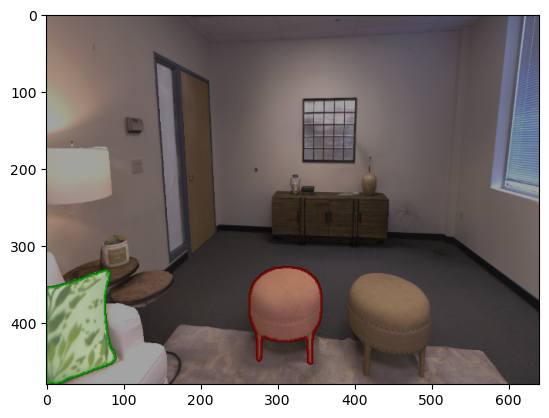

In [5]:
def compute_norm_dist(obj_a, obj_b):
    '''
    Compute the distance between two objects, normalized by their extents
    '''
    points_a = np.asarray(obj_a['pcd'].points)
    center_a = points_a.mean(axis=0)
    extent_a = points_a.max(axis=0) - points_a.min(axis=0)
    
    points_b = np.asarray(obj_b['pcd'].points)
    center_b = points_b.mean(axis=0)
    extent_b = points_b.max(axis=0) - points_b.min(axis=0)
    
    dist = np.absolute(center_a - center_b)
    norm_dist = dist / ((extent_a + extent_b) / 2.0)
    
    return norm_dist
    
def compute_mutual_vis_ratio(obj_a, obj_b):
    '''
    Compute the product the visibility ratio of a pair of objects. 
    
    Visibility ratio is the ratio between the number of points visible in one view 
    and that of the fully built 3D object. 
    
    In order for GPT to reason about the relationship between two objects, we want 
    to get some images where both objects are mostly visible. So we compute this ratio
    and use it to select relevant images. 
    '''
    n_images = max(
        np.asarray(obj_a['image_idx']).max(),
        np.asarray(obj_b['image_idx']).max()
    ) + 1
    
    n_points_a = len(obj_a['pcd'].points)
    n_points_b = len(obj_b['pcd'].points)
    
    vis_ratio_a = np.zeros(n_images)
    vis_ratio_b = np.zeros(n_images)

    image_idx_a = np.asarray(obj_a['image_idx'])
    image_idx_b = np.asarray(obj_b['image_idx'])
    
    vis_points_a = np.asarray(obj_a['n_points'])
    vis_points_b = np.asarray(obj_b['n_points'])
    
    vis_ratio_a[image_idx_a] = vis_points_a / n_points_a
    vis_ratio_b[image_idx_b] = vis_points_b / n_points_b
    
    mutual_vis_ratio = vis_ratio_a * vis_ratio_b
    
    return mutual_vis_ratio

def resize_mask(mask, h, w):
    mask = mask.astype(float)
    mask = cv2.resize(mask, (w, h), interpolation=cv2.INTER_NEAREST)
    mask = (mask > 0.5)
    return mask

def draw_mask_on_image(mask, image, color):
    '''
    Draw the mask on image. The contour of the mask is first computed and draw on the 
    image in dark color (e.g. dark red). Then the inner region of the mask is draw on 
    image in light color (e.g. light red). The original content of the image in the
    masked region will still be visible
    
    mask: numpy.ndarray of shape (H, W), dtype bool
    image: numpy.ndarray of shape (H, W, 3), dtype uint8
    '''
    # Copy the image to avoid altering the original
    output_image = image.copy()

    # Create a colored version of the mask
    colored_mask = np.zeros_like(image, dtype=np.uint8)
    
    # Create darker and lighter shades of the provided color
    darker_color = tuple([x // 2 for x in color])  # Darken by reducing brightness by half
    lighter_color = tuple([min(x + 100, 255) for x in color])  # Lighten by increasing brightness

    # Find contours of the mask
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Draw the contours with the darker color
    cv2.drawContours(output_image, contours, -1, darker_color, 2)

    # Draw the filled mask with the lighter color, use a blend to keep underlying details
    colored_mask[mask] = lighter_color
    cv2.addWeighted(output_image, 0.8, colored_mask, 0.2, 0, output_image)

    return output_image

n_objects = len(objects)

for i in range(1, n_objects):
    for j in range(i+1, n_objects):
        obj_a = objects[i]
        obj_b = objects[j]
        
        # filter object pairs by their geometric distance
        norm_dist = compute_norm_dist(obj_a, obj_b)
        
        if norm_dist.max() > 2.0:
            # Skip this pair as they are too far away
            continue
        
        # print(f"Object a {i}: {Counter(obj_a['class_name'])}")
        # print(f"Object b {j}: {Counter(obj_b['class_name'])}")
        # print(f"Norm dist: {norm_dist}")
        
        # Get the image with maximum mutual visiblity ratio
        mutual_vis_ratio = compute_mutual_vis_ratio(obj_a, obj_b)
        image_id, max_mutual_vis_ratio = mutual_vis_ratio.argmax(), mutual_vis_ratio.max()
        
        # print(image_id, max_mutual_vis_ratio)
        color, _, _, _ = dataset[image_id]
        color = color.detach().cpu().numpy()
        color = color.round().astype(np.uint8)
        
        det_id_a = np.where(np.asarray(obj_a['image_idx']) == image_id)[0][0]
        mask_a = obj_a['mask'][det_id_a]
        mask_a = resize_mask(mask_a, color.shape[0], color.shape[1])
        
        det_id_b = np.where(np.asarray(obj_b['image_idx']) == image_id)[0][0]
        mask_b = obj_b['mask'][det_id_b]
        mask_b = resize_mask(mask_b, color.shape[0], color.shape[1])
        
        # plt.imshow(color); plt.show()
        # plt.imshow(mask_a); plt.show()
        # plt.imshow(mask_b); plt.show()
        
        blend_image = draw_mask_on_image(mask_a, color, (255, 0, 0))
        blend_image = draw_mask_on_image(mask_b, blend_image, (0, 255, 0))
        
        plt.imshow(blend_image)
        plt.show()
        
        break
    break